### **Implements: Sequence to Sequence Learning with Neural Networks**

In this implementation we will build and train a lightweight sequence to sequence translation model proposed in this seminal <a href="https://arxiv.org/abs/1409.3215">paper</a>

The seq2seq model introduced in the paper uses two multilayered Long Short-Term Memory (LSTMs) models - one encodes the input sequence to a fixed-length vector and the other decodes the output sequence from this vector. We try to repoduce a small scale version of the architecture described in the paper.

<img src="assets/model.png" />

Our model will be trained to translate one language into another, in our case German to English. We will use a small chunk of the German-English corpus of <a href="bentrevett/multi30k">Multi30K dataset</a>.

<img src="assets/data.png" />

Using device: cpu

MODEL INFO
Architecture: Seq2Seq with LSTM
Size: 9.45M
Hidden dim: 512
Embedding dim: 256
Num layers: 2
Total: 9,451,255
Trainable: 9,451,255

DATA INFO
Multi30k Dataset (German-English)
Train samples: 4000
Validation samples: 1000
Source vocabulary size: 2058
Target vocabulary size: 2039

epoch: 1/50, train_loss: 4.831, batch: 63/63, mfu: 0.35%
epoch: 1/50, train_loss: 5.342, val_loss: 4.683
epoch: 2/50, train_loss: 4.646, batch: 63/63, mfu: 0.35%
epoch: 2/50, train_loss: 4.870, val_loss: 4.592
epoch: 3/50, train_loss: 4.903, batch: 63/63, mfu: 0.35%
epoch: 3/50, train_loss: 4.683, val_loss: 4.602
epoch: 4/50, train_loss: 4.506, batch: 63/63, mfu: 0.35%
epoch: 4/50, train_loss: 4.587, val_loss: 4.620
epoch: 5/50, train_loss: 4.274, batch: 63/63, mfu: 0.35%
epoch: 5/50, train_loss: 4.482, val_loss: 4.690
epoch: 6/50, train_loss: 4.292, batch: 63/63, mfu: 0.35%
epoch: 6/50, train_loss: 4.382, val_loss: 4.653
epoch: 7/50, train_loss: 4.385, batch: 63/63, mfu: 0.35%
epo

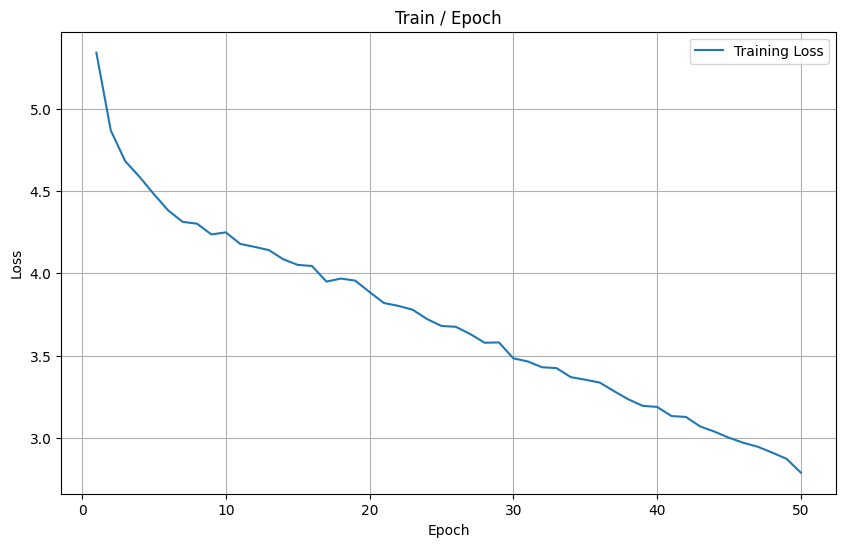


Sample from trained weight:

Input (German): . auto einem in jemandem mit <unk> typ ein
Target (English): a guy is <unk> with someone in a car .
Model Output (English): man in a <unk> <unk> .


/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_98069/1523997237.py:402: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_mode

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from datasets import load_dataset
import os
import json
import random
import spacy
import matplotlib.pyplot as plt
from collections import Counter

"""Implements: Sequence to Sequence Learning with Neural Networks"""

# Hyperparameters
num_layers = 2
embedding_dim = 256
hidden_dim = 512
batch_size = 64
dropout = 0.5
learning_rate = 0.001
clip = 1.0
num_epochs = 50

# ==============================
# Data Preprocessing 
# ==============================
def prep_data():
    if not os.path.exists('data/train.jsonl') or not os.path.exists('data/valid.jsonl'):
        os.makedirs('data', exist_ok=True)
        dataset = load_dataset("bentrevett/multi30k", split="train")
        
        data = [{"de": item["de"], "en": item["en"]} for item in dataset]
        train_data = data[:4000]
        val_data = data[4000:5000]
        
        def save_data(data, filename):
            with open(filename, 'w', encoding='utf-8') as f:
                for item in data:
                    json.dump(item, f)
                    f.write('\n')
        
        save_data(train_data, "data/train.jsonl")
        save_data(val_data, "data/valid.jsonl")

# ==============================
# Tokenize
# ==============================

# Load spacy tokenizers for German and English (first download)
# !python3 -m spacy download en_core_web_sm
# !python3 -m spacy download de_core_news_sm
spacy_de = spacy.load("de_core_news_sm") # German
spacy_en = spacy.load("en_core_web_sm") # English

def tokenize_de(text):
    """Given a string of German text tokenize and return a reversed list of strings (tokens)"""
    return [tok.text.lower() for tok in spacy_de.tokenizer(text)][::-1]

def tokenize_en(text):
    """Tokenizes English text"""
    return [tok.text.lower() for tok in spacy_en.tokenizer(text)]

class Vocab(Dataset):
    def __init__(self, file_path: str, src_tokenizer, tgt_tokenizer, src_vocab=None, tgt_vocab=None):
        self.data = []
        self.src_words = Counter()
        self.tgt_words = Counter()
        
        # First pass: collect word frequencies
        # print("First pass: collecting word frequencies...")
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                sample = json.loads(line)
                src_tokens = src_tokenizer(sample['de'].strip())
                tgt_tokens = tgt_tokenizer(sample['en'].strip())
                self.src_words.update(src_tokens)
                self.tgt_words.update(tgt_tokens)
        
        # Build vocab
        if src_vocab is None:
            self.src_vocab = self._build_vocab(self.src_words)
        else:
            self.src_vocab = src_vocab
            
        if tgt_vocab is None:
            self.tgt_vocab = self._build_vocab(self.tgt_words)
        else:
            self.tgt_vocab = tgt_vocab
            
        self.src_idx2word = {idx: word for word, idx in self.src_vocab.items()}
        self.tgt_idx2word = {idx: word for word, idx in self.tgt_vocab.items()}
        
        # Second pass: create dataset
        # print("Second pass: creating dataset...")
        with open(file_path, 'r', encoding='utf-8') as f:
            for line in f:
                sample = json.loads(line)
                src_tokens = src_tokenizer(sample['de'].strip())
                tgt_tokens = tgt_tokenizer(sample['en'].strip())
                
                if len(src_tokens) > 0 and len(tgt_tokens) > 0:
                    src_indices = self._tokens_to_indices(src_tokens, self.src_vocab)
                    tgt_indices = self._tokens_to_indices(tgt_tokens, self.tgt_vocab)
                    self.data.append((src_indices, tgt_indices))
    
    def _build_vocab(self, counter, min_freq=2):
        vocab = {'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3}
        for word, count in counter.items():
            if count >= min_freq:
                vocab[word] = len(vocab)
        return vocab
    
    def _tokens_to_indices(self, tokens, vocab):
        return [vocab.get(token, vocab['<unk>']) for token in tokens]
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        src_indices, tgt_indices = self.data[idx]
        src_indices = [self.src_vocab['<sos>']] + src_indices + [self.src_vocab['<eos>']]
        tgt_indices = [self.tgt_vocab['<sos>']] + tgt_indices + [self.tgt_vocab['<eos>']]
        return torch.tensor(src_indices), torch.tensor(tgt_indices)

def collate_fn(batch):
    src_batch, tgt_batch = zip(*batch)
    src_batch = pad_sequence(src_batch, batch_first=True, padding_value=0)
    tgt_batch = pad_sequence(tgt_batch, batch_first=True, padding_value=0)
    return src_batch, tgt_batch

# ==============================
# Seq2Seq Model
# ==============================

class Encoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                          dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.dropout(self.embedding(x))
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers,
                          dropout=dropout if num_layers > 1 else 0, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden, cell):
        x = x.unsqueeze(1)
        embedded = self.dropout(self.embedding(x))
        output, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        prediction = self.fc(output.squeeze(1))
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt, teacher_forcing_ratio=0.5):
        batch_size = src.size(0)
        tgt_len = tgt.size(1)
        tgt_vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, tgt_vocab_size).to(self.device)
        hidden, cell = self.encoder(src)

        input = tgt[:, 0]
        for t in range(1, tgt_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[:, t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            input = tgt[:, t] if teacher_force else output.argmax(1)

        return outputs
    
# ==============================
# Eval
# ==============================

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            output = model(src, tgt, 0.0)  # No teacher forcing during eval
            
            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            tgt = tgt[:, 1:].reshape(-1)
            
            loss = criterion(output, tgt)
            batch_tokens = (tgt != 0).sum().item()
            total_tokens += batch_tokens
            total_loss += loss.item() * batch_tokens
    
    return total_loss / total_tokens

# ==============================
# Train
# ==============================

def train(model, loader, optimizer, criterion, clip, epoch, total_epochs, device):
    model.train()
    total_loss = 0
    total_tokens = 0
    
    # Calculate total number of batches
    num_batches = len(loader)
    
    # FLOPS calculation
    hidden_size = model.encoder.lstm.hidden_size
    embed_size = model.encoder.embedding.embedding_dim
    num_layers = model.encoder.lstm.num_layers
    flops_per_token = 4 * (embed_size + hidden_size) * hidden_size * 2 * num_layers * 2
    cpu_peak_flops = 100e9
    
    for batch_idx, (src, tgt) in enumerate(loader, 1):
        src, tgt = src.to(device), tgt.to(device)
        
        optimizer.zero_grad()
        output = model(src, tgt)
        
        output_dim = output.shape[-1]
        output = output[:, 1:].reshape(-1, output_dim)
        tgt = tgt[:, 1:].reshape(-1)
        
        loss = criterion(output, tgt)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        
        batch_tokens = (tgt != 0).sum().item()
        total_tokens += batch_tokens
        total_loss += loss.item() * batch_tokens
        
        # Calc mfu
        tokens_per_sec = total_tokens / ((batch_idx * len(src)) + 1e-8)
        achieved_flops = tokens_per_sec * flops_per_token
        mfu = (achieved_flops / cpu_peak_flops) * 100
        
        print(f"epoch: {epoch}/{total_epochs}, train_loss: {loss.item():.3f}, "
              f"batch: {batch_idx}/{num_batches}, mfu: {mfu:.2f}%", end='\r')
    
    return total_loss / total_tokens

# ==============================
# Sample
# ==============================

def translate(model, dataset, device, n_samples=5):
    model.eval()
    print("\nSample from trained weight:")
    
    for _ in range(n_samples):
        idx = random.randint(0, len(dataset) - 1)
        src, tgt = dataset[idx]
        src = src.unsqueeze(0).to(device)
        
        with torch.no_grad():
            hidden, cell = model.encoder(src)
            input_token = torch.tensor([dataset.tgt_vocab['<sos>']]).to(device)
            
            translated_tokens = []
            for _ in range(100):  # max length of 100 tokens
                output, hidden, cell = model.decoder(input_token, hidden, cell)
                top_token = output.argmax(1).item()
                
                if top_token == dataset.tgt_vocab['<eos>']:
                    break
                    
                word = dataset.tgt_idx2word[top_token]
                translated_tokens.append(word)
                input_token = torch.tensor([top_token]).to(device)
        
        # Get original source and target text
        src_text = ' '.join([dataset.src_idx2word[idx.item()] for idx in src[0]
                           if dataset.src_idx2word[idx.item()] not in ['<sos>', '<eos>', '<pad>']])
        tgt_text = ' '.join([dataset.tgt_idx2word[idx.item()] for idx in tgt
                           if dataset.tgt_idx2word[idx.item()] not in ['<sos>', '<eos>', '<pad>']])
        
        print(f"\nInput (German): {src_text}")
        print(f"Target (English): {tgt_text}")
        print(f"Model Output (English): {' '.join(translated_tokens)}")

    
# ==============================
# Main
# ==============================

def main():
    # Set seed, why not?
    SEED = 42
    random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    
    # Prepare data
    prep_data()
    
    # Autodetect device (gpu poor? use cpu)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    train_dataset = Vocab('data/train.jsonl', tokenize_de, tokenize_en)
    val_dataset = Vocab('data/valid.jsonl', tokenize_de, tokenize_en,
                                   train_dataset.src_vocab, train_dataset.tgt_vocab)
    
    # Load data
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                            shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,
                          shuffle=False, collate_fn=collate_fn)
    
    # Initialize model
    encoder = Encoder(len(train_dataset.src_vocab), embedding_dim,
                     hidden_dim, num_layers, dropout)
    decoder = Decoder(len(train_dataset.tgt_vocab), embedding_dim,
                     hidden_dim, num_layers, dropout)
    model = Seq2Seq(encoder, decoder, device).to(device)

    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print("\nMODEL INFO")
    print("Architecture: Seq2Seq with LSTM")
    print(f"Size: {trainable_params/1e6:.2f}M")
    print(f"Hidden dim: {hidden_dim}")
    print(f"Embedding dim: {embedding_dim}")
    print(f"Num layers: {num_layers}")
    print(f"Total: {total_params:,}")
    print(f"Trainable: {trainable_params:,}")

    print(f"\nDATA INFO")
    print(f"Multi30k Dataset (German-English)")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Source vocabulary size: {len(train_dataset.src_vocab)}")
    print(f"Target vocabulary size: {len(train_dataset.tgt_vocab)}\n")
    
    # Initialize weights
    def init_weights(m):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.normal_(param.data, mean=0, std=0.01)
            else:
                nn.init.constant_(param.data, 0)
    model.apply(init_weights)
    
    # Set optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss(ignore_index=train_dataset.tgt_vocab['<pad>'])
    
    # Train
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    
    for epoch in range(1, num_epochs + 1):
        train_loss = train(model, train_loader, optimizer, criterion,
                               clip, epoch, num_epochs, device)
        val_loss = evaluate(model, val_loader, criterion, device)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        print(f"\nepoch: {epoch}/{num_epochs}, train_loss: {train_loss:.3f}, "
              f"val_loss: {val_loss:.3f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pt')
            # print("Best model saved.")
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Train / Epoch')
    plt.legend()
    plt.show()
    
    # Sample
    model.load_state_dict(torch.load('best_model.pt'))
    translate(model, val_dataset, device)

# LFG!!
main()

In [133]:
train_dataset = Vocab('data/train.jsonl', tokenize_de, tokenize_en)
val_dataset = Vocab('data/valid.jsonl', tokenize_de, tokenize_en,
                                train_dataset.src_vocab, train_dataset.tgt_vocab)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

train_loader = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size,
                        shuffle=False, collate_fn=collate_fn)

encoder = Encoder(len(train_dataset.src_vocab), embedding_dim,
                    hidden_dim, num_layers, dropout)
decoder = Decoder(len(train_dataset.tgt_vocab), embedding_dim,
                    hidden_dim, num_layers, dropout)
model = Seq2Seq(encoder, decoder, device).to(device)

model.load_state_dict(torch.load('best_model.pt'))
translate(model, val_dataset, device, n_samples=10)

Using device: cpu

Sample from trained weight:

Input (German): . gras dem auf <unk> dem mit personen zwei
Target (English): two <unk> with top of heads on grass .
Model Output (English): two dogs are in the .

Input (German): . <unk> hand seiner aus <unk> ein wie , sehen sie <unk> , <unk> sehr sind kinder
Target (English): children are very excited to see a <unk> eating food from his hand .
Model Output (English): there are a group of people are <unk> a a a a a a . .

Input (German): . boot einem in sitzen männer gekleidete blau zwei
Target (English): two men in blue clothing sit on a boat .
Model Output (English): two men in a <unk> are playing .

Input (German): . <unk> <unk> um , dach dem auf kniet person männliche erwachsene eine
Target (English): an adult male is kneeling on top of a roof make repairs
Model Output (English): a <unk> <unk> <unk> <unk> <unk> a <unk> <unk> .

Input (German): . zu hügel <unk> einen auf wiese eine über rennen mädchen ein und junge ein
Target (English)

/var/folders/lv/fs2j5vr90zz71f7mbvytr3s80000gn/T/ipykernel_98069/4009759217.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model